## EvalML and Pycaret

- # 1. AutoML EvalML time series

In [24]:
import pandas as pd
from evalml.demos import load_weather

In [25]:
X, y = load_weather()

             Number of Features
Categorical                   1

Number of training examples: 3650
Targets
10.0    1.40%
11.0    1.40%
13.0    1.32%
12.5    1.21%
10.5    1.21%
        ...  
0.2     0.03%
24.0    0.03%
25.2    0.03%
22.7    0.03%
21.6    0.03%
Name: Temp, Length: 229, dtype: object


In [32]:
# weather_data=X
# weather_data['temp']=y
# weather_data.to_csv('weather_data.csv', index =False)

In [7]:
X,y

(           Date
 0    1981-01-01
 1    1981-01-02
 2    1981-01-03
 3    1981-01-04
 4    1981-01-05
 ...         ...
 3647 1990-12-27
 3648 1990-12-28
 3649 1990-12-29
 3650 1990-12-30
 3651 1990-12-31
 
 [3652 rows x 1 columns],
 0       20.7
 1       17.9
 2       18.8
 3       14.6
 4       15.8
         ... 
 3647    14.0
 3648    13.6
 3649    13.5
 3650    15.7
 3651    13.0
 Name: Temp, Length: 3652, dtype: float64)

In [11]:
train_dates, test_dates= X.Date<'1990-01-01',X.Date>='1990-01-01'
X_train, y_train = X.ww.loc[train_dates], y.ww.loc[train_dates]
X_test, y_test = X.ww.loc[test_dates], y.ww.loc[test_dates]

# Visualizing the training set

In [20]:
import plotly.graph_objects as go

In [22]:
data = [
    go.Scatter(
        x=X_train["Date"],
        y=y_train,
        mode="lines+markers",
        name="Temperature (C)",
        line=dict(color="#1f77b4"),
    )
]
# Let plotly pick the best date format.
layout = go.Layout(
    title={"text": "Min Daily Temperature, Melbourne 1980-1989"},
    xaxis={"title": "Time"},
    yaxis={"title": "Temperature (C)"},
)

go.Figure(data=data, layout=layout)

In [23]:
from evalml.pipelines.components import TimeSeriesImputer

ts_imputer = TimeSeriesImputer(
    categorical_impute_strategy="forwards_fill",
    numeric_impute_strategy="backwards_fill",
    target_impute_strategy="interpolate",
)
X_train, y_train = ts_imputer.fit_transform(X_train, y_train)

In [27]:
print(f"Inferred frequency: {pd.infer_freq(X_train['Date'])}")
print(f"NaNs in training data: {X_train['Date'].isna().any()}")
# print(f"NaNs in other training data columns: {X_train['Categorical'].isna().any() or X_train['Numeric'].isna().any()}")
print(f"NaNs in target data: {y_train.isna().any()}")

Inferred frequency: D
NaNs in training data: False
NaNs in target data: False


# Running AutoML Search

In [28]:
from evalml.automl import AutoMLSearch

problem_config = {"gap": 0, "max_delay": 7, "forecast_horizon": 7, "time_index": "Date"}

automl = AutoMLSearch(
    X_train,
    y_train,
    problem_type="time series regression",
    max_batches=1,
    problem_configuration=problem_config,
    automl_algorithm="iterative",
    allowed_model_families=[
        "xgboost",
        "random_forest",
        "linear_model",
        "extra_trees",
    ],
)

c:\Users\zeesh\anaconda3\envs\forecating_env\lib\site-packages\evalml\automl\automl_search.py:544: UserWarning:

Time series support in evalml is still in beta, which means we are still actively building its core features. Please be mindful of that when running search().



In [29]:
automl.search()

c:\Users\zeesh\anaconda3\envs\forecating_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+04, tolerance: 5.427e+00

c:\Users\zeesh\anaconda3\envs\forecating_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e+04, tolerance: 5.431e+00

c:\Users\zeesh\anaconda3\envs\forecating_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.407e+04, tolerance: 5.439e+00



{1: {'Elastic Net Regressor w/ Imputer + Time Series Featurizer + STL Decomposer + DateTime Featurizer + Drop NaN Rows Transformer + Standard Scaler': 28.81020498275757,
  'Elastic Net Regressor w/ Imputer + Time Series Featurizer + DateTime Featurizer + Drop NaN Rows Transformer + Standard Scaler': 3.248133420944214,
  'XGBoost Regressor w/ Imputer + Time Series Featurizer + STL Decomposer + DateTime Featurizer': 30.6701762676239,
  'XGBoost Regressor w/ Imputer + Time Series Featurizer + DateTime Featurizer': 2.6279666423797607,
  'Random Forest Regressor w/ Imputer + Time Series Featurizer + STL Decomposer + DateTime Featurizer + Drop NaN Rows Transformer': 26.824843883514404,
  'Random Forest Regressor w/ Imputer + Time Series Featurizer + DateTime Featurizer + Drop NaN Rows Transformer': 3.6669020652770996,
  'Extra Trees Regressor w/ Imputer + Time Series Featurizer + STL Decomposer + DateTime Featurizer + Drop NaN Rows Transformer': 30.94228196144104,
  'Extra Trees Regressor w/

# Evaluate best pipeline on test data

In [30]:
pl = automl.best_pipeline

pl.fit(X_train, y_train)

best_pipeline_score = pl.score(X_test, y_test, ["MedianAE"], X_train, y_train)[
    "MedianAE"
]

In [31]:
best_pipeline_score

1.5543018420342083

In [33]:
baseline = automl.get_pipeline(0)
baseline.fit(X_train, y_train)
naive_baseline_score = baseline.score(X_test, y_test, ["MedianAE"], X_train, y_train)[
    "MedianAE"
]

In [34]:
naive_baseline_score

2.3

In [35]:
automl.objective.calculate_percent_difference(best_pipeline_score, naive_baseline_score)

32.42165904199094

# Visualize the predictions over time

In [36]:
from evalml.model_understanding import graph_prediction_vs_actual_over_time

fig = graph_prediction_vs_actual_over_time(
    pl, X_test, y_test, X_train, y_train, dates=X_test["Date"]
)
fig

# Predicting on unseen data

In [37]:
pl.predict_in_sample(X_test, y_test, objective=None, X_train=X_train, y_train=y_train)

3287    14.106508
3288    14.398005
3289    14.420201
3290    13.658261
3291    12.970367
          ...    
3647    13.699798
3648    13.337252
3649    13.056601
3650    13.314847
3651    12.660095
Name: Temp, Length: 365, dtype: float64

# Multi timeseries problem

In [38]:
import numpy as np

time_index = list(pd.date_range(start="1/1/2018", periods=50)) * 2
series_id = pd.Series([1] * 50 + [2] * 50, dtype="str")

series_1_target = pd.Series(10 * np.sin(np.arange(50)) + np.random.rand(50))
series_2_target = pd.Series(range(50) + np.random.rand(50))
target = pd.Series(
    pd.concat([series_1_target, series_2_target]), name="target"
).reset_index(drop=True)

data = (
    pd.DataFrame(
        {
            "date": time_index,
            "series_id": series_id,
            "target": target,
        },
    )
    .sort_values("date")
    .reset_index(drop=True)
)
X = data.drop(["target"], axis=1)
y = data["target"]

In [40]:
data

,date,series_id,target
0,2018-01-01,1,0.275950
1,2018-01-01,2,0.650208
2,2018-01-02,1,8.882726
3,2018-01-02,2,1.065106
4,2018-01-03,1,9.495362
...,...,...,...
95,2018-02-17,1,1.578877
96,2018-02-18,2,48.781742
97,2018-02-18,1,-7.241185
98,2018-02-19,1,-9.527894


In [41]:
from evalml.preprocessing import split_multiseries_data

X_train, X_holdout, y_train, y_holdout = split_multiseries_data(
    X, y, series_id="series_id", time_index="date"
)

# Running AutoMLSearch

In [42]:
problem_configuration = {
    "time_index": "date",
    "forecast_horizon": 5,
    "max_delay": 10,
    "gap": 0,
    "series_id": "series_id",
}

automl = AutoMLSearch(
    X_train,
    y_train,
    problem_type="multiseries time series regression",
    problem_configuration=problem_configuration,
)
automl.search()

c:\Users\zeesh\anaconda3\envs\forecating_env\lib\site-packages\evalml\automl\automl_search.py:544: UserWarning:

Time series support in evalml is still in beta, which means we are still actively building its core features. Please be mindful of that when running search().

c:\Users\zeesh\anaconda3\envs\forecating_env\lib\site-packages\scipy\linalg\_solvers.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=8.65949e-55): result may not be accurate.

c:\Users\zeesh\anaconda3\envs\forecating_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\zeesh\anaconda3\envs\forecating_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\zeesh\anaconda3\envs\forecating_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check 

{1: {'VARMAX Regressor w/ STL Decomposer': 3.975646495819092,
  'VARMAX Regressor': 1.7585639953613281,
  'Total time of batch': 8.84614872932434}}

In [43]:
automl.rankings

,id,pipeline_name,search_order,ranking_score,mean_cv_score,standard_deviation_cv_score,percent_better_than_baseline,high_variance_cv,parameters
0,1,VARMAX Regressor w/ STL Decomposer,1,0.673505,0.673505,0.098441,87.305697,False,"{'STL Decomposer': {'degree': 1, 'period': Non..."
1,0,Multiseries Time Series Baseline Pipeline,0,5.305568,5.305568,0.018755,0.000000,False,{'Time Series Featurizer': {'time_index': 'dat...
2,2,VARMAX Regressor,2,6.710273,6.710273,2.052718,-26.476058,False,"{'VARMAX Regressor': {'order': (1, 0), 'trend'..."


# Visualizing the data and results

In [51]:
from evalml.pipelines.utils import unstack_multiseries

X_unstacked, y_unstacked = unstack_multiseries(
    X, y, series_id="series_id", time_index="date", target_name="target"
)
y_unstacked.head(10)

,target|1,target|2
0,0.275950,0.650208
1,8.882726,1.065106
2,9.495362,2.440664
3,1.611724,3.001629
4,-7.146176,4.619406
5,-8.701478,5.694040
6,-1.991660,6.997415
7,7.250428,7.403482
8,10.656244,8.638625
9,4.504001,9.228816


In [45]:
from evalml.pipelines.components import STLDecomposer

{'target|1': (<Figure size 1850x1450 with 4 Axes>,
  array([<AxesSubplot: title={'center': 'signal'}>,
         <AxesSubplot: title={'center': 'trend'}>,
         <AxesSubplot: title={'center': 'seasonality'}>,
         <AxesSubplot: title={'center': 'residual'}>], dtype=object)),
 'target|2': (<Figure size 1850x1450 with 4 Axes>,
  array([<AxesSubplot: title={'center': 'signal'}>,
         <AxesSubplot: title={'center': 'trend'}>,
         <AxesSubplot: title={'center': 'seasonality'}>,
         <AxesSubplot: title={'center': 'residual'}>], dtype=object))}

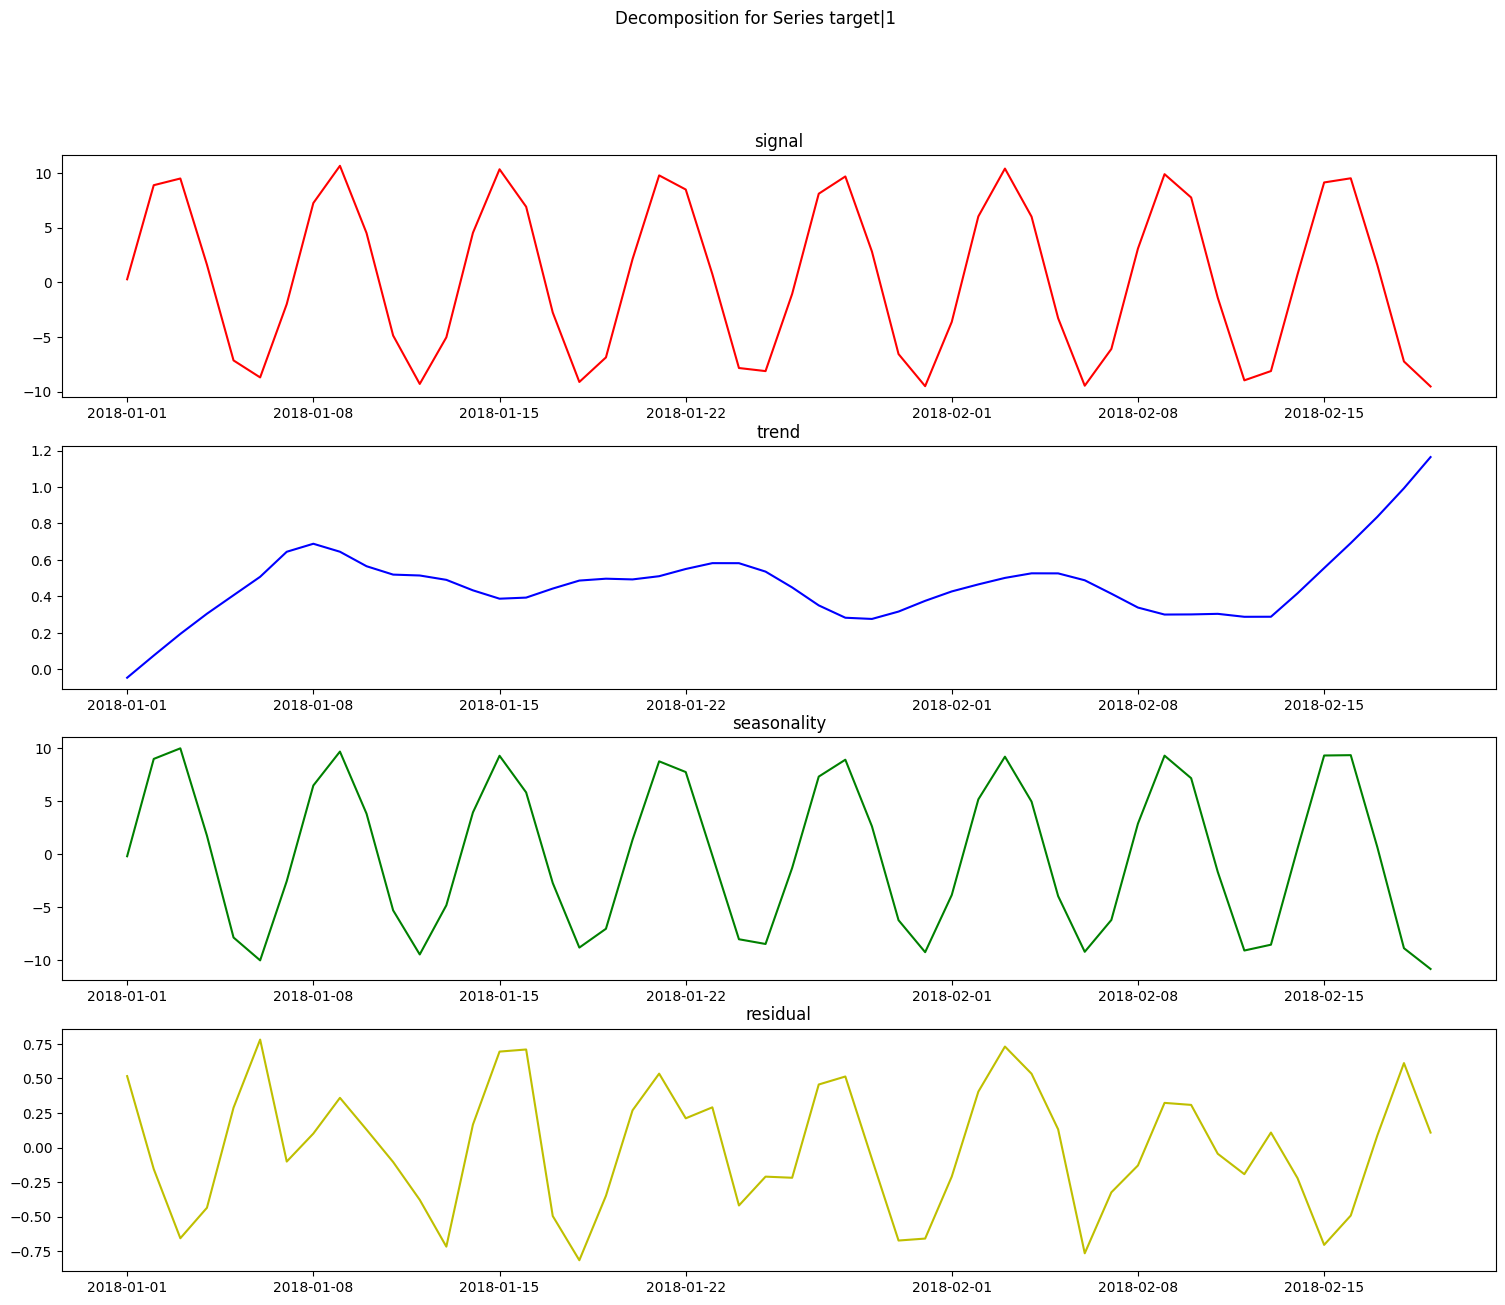

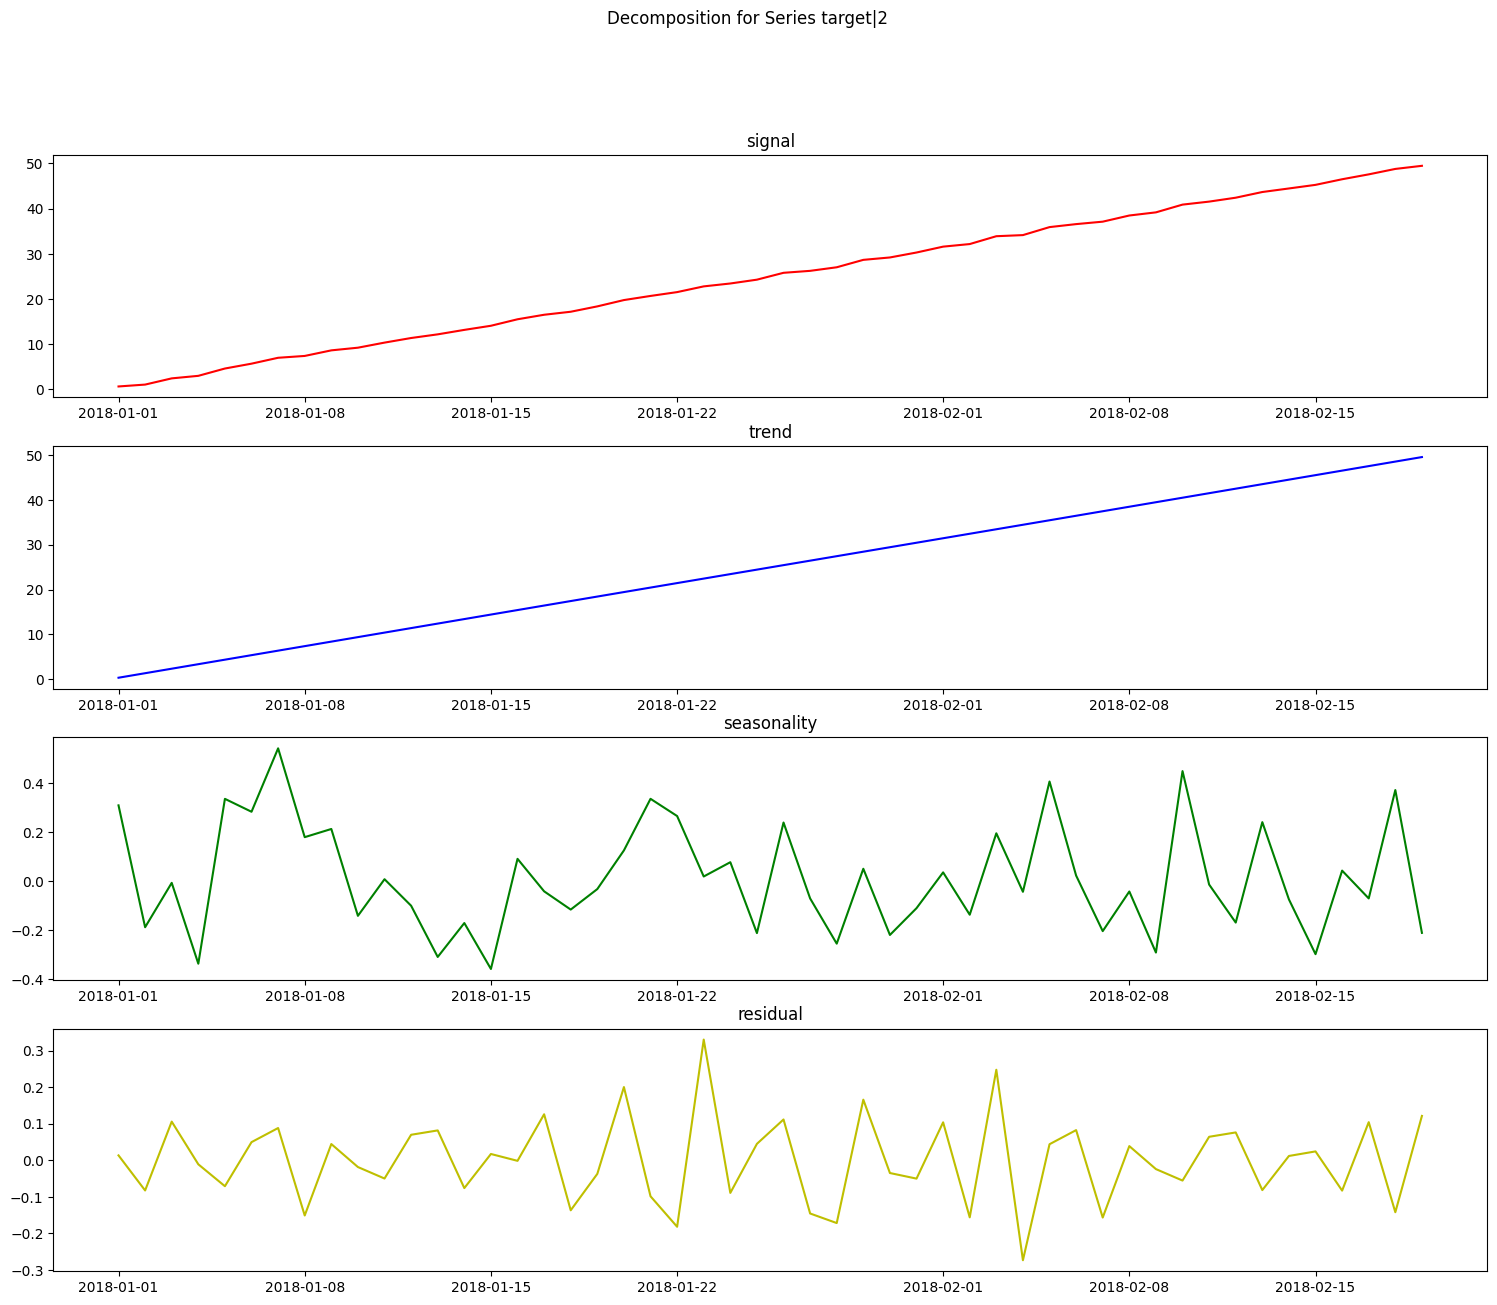

In [52]:
decomposer = STLDecomposer(time_index="date", series_id="series_id")
decomposer.fit(X_unstacked, y_unstacked)

decomposer.plot_decomposition(X_unstacked, y_unstacked)

# Prediction vs Actual

In [53]:
pipeline = automl.best_pipeline
fig = graph_prediction_vs_actual_over_time(
    pipeline, X_holdout, y_holdout, X_train, y_train, dates=X_holdout["date"]
)
fig

In [54]:
fig = graph_prediction_vs_actual_over_time(
    pipeline,
    X_holdout,
    y_holdout,
    X_train,
    y_train,
    dates=X_holdout["date"],
    single_series="2",
)
fig

- # 2. AutoML Pycaret time series

In [14]:
# read csv file
import pandas as pd
data = pd.read_csv('AirPassengers.csv')
data.columns=['Date','Passengers']
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [17]:
# create 12 month moving average
data['MA12'] = data['Passengers'].rolling(12).mean()

# plot the data and MA
import plotly.express as px
fig = px.line(data, x="Date", y=["Passengers", "MA12"], template = 'plotly_dark')
fig.show()

In [19]:
import numpy as np
# extract month and year from dates**
data['Month'] = [i.month for i in data['Date']]
data['Year'] = [i.year for i in data['Date']]

# create a sequence of numbers
data['Series'] = np.arange(1,len(data)+1)

# drop unnecessary columns and re-arrange
data.drop(['Date', 'MA12'], axis=1, inplace=True)
data = data[['Series', 'Year', 'Month', 'Passengers']] 

# check the head of the dataset**
data.head()

,Series,Year,Month,Passengers
0,1,1949,1,112
1,2,1949,2,118
2,3,1949,3,132
3,4,1949,4,129
4,5,1949,5,121


In [21]:
# split data into train-test set
train = data[data['Year'] < 1960]
test = data[data['Year'] >= 1960]

# check shape
train.shape, test.shape


((132, 4), (12, 4))

In [23]:
# import the regression module**
from pycaret.regression import *

# initialize setup**
s = setup(data = train, test_data = test, target = 'Passengers', fold_strategy = 'timeseries', numeric_features = ['Year', 'Series'], fold = 3, transform_target = True, session_id = 123)

ValueError: Invalid value for the fold_strategy parameter. 'timeseries' requires 'data_split_shuffle' and 'fold_shuffle' to be False as it can lead to unexpected data split.

In [ ]:
best = compare_models(sort = 'MAE')

In [ ]:
prediction_holdout = predict_model(best);

In [ ]:
**# generate predictions on the original dataset**
predictions = predict_model(best, data=data)

**# add a date column in the dataset**
predictions['Date'] = pd.date_range(start='1949-01-01', end = '1960-12-01', freq = 'MS')

**# line plot**
fig = px.line(predictions, x='Date', y=["Passengers", "Label"], template = 'plotly_dark')

**# add a vertical rectange for test-set separation**
fig.add_vrect(x0="1960-01-01", x1="1960-12-01", fillcolor="grey", opacity=0.25, line_width=0)fig.show()

In [ ]:
final_best = finalize_model(best)

# Create a future scoring dataset

In [3]:
future_dates = pd.date_range(start = '1961-01-01', end = '1965-01-01', freq = 'MS')
future_df = pd.DataFrame()
future_df['Month'] = [i.month for i in future_dates]
future_df['Year'] = [i.year for i in future_dates]    
future_df['Series'] = np.arange(145 (145+len(future_dates)))future_df.head()

SyntaxError: invalid syntax (4046837955.py, line 5)

In [ ]:
predictions_future = predict_model(final_best, data=future_df)
predictions_future.head()

# Plot the actual data and predictions

In [ ]:
concat_df = pd.concat([data,predictions_future], axis=0)
concat_df_i = pd.date_range(start='1949-01-01', end = '1965-01-01', freq = 'MS')
concat_df.set_index(concat_df_i, inplace=True)fig = 

px.line(concat_df, x=concat_df.index, y=["Passengers", "Label"], template = 'plotly_dark')
fig.show()

- # 3. Prophet forecasting

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import plotly.express as px


In [35]:
df= pd.read_csv('weather_data.csv')
df

,Date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3647,1990-12-27,14.0
3648,1990-12-28,13.6
3649,1990-12-29,13.5
3650,1990-12-30,15.7


In [48]:
# sns.lineplot(x='Date', y='temp', data=df)
fig=px.line(df,x='Date', y='temp')
fig.update_xaxes(rangeslider_visible=True,
                rangeselector=dict(
                buttons=list([
                dict(count=1,label='1m', step="month", stepmode="backward"),
                dict(count=6,label='6m', step="month", stepmode="backward"),
                dict(count=1,label='YTD', step="year", stepmode="todate"),
                dict(count=1,label='1y', step="year", stepmode="backward"),
                dict(step='all')
            ])
        )
    )
fig.show()


## converting data to montly wise

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3652 non-null   datetime64[ns]
 1   temp    3652 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [57]:
df['Date']=pd.to_datetime(df['Date'])

In [65]:
df1=df.set_index('Date').resample('M').mean().round(2)
df1.reset_index(inplace=True)
df1.columns=['ds','y']
df1

,ds,y
0,1981-01-31,17.71
1,1981-02-28,17.68
2,1981-03-31,13.50
3,1981-04-30,12.36
4,1981-05-31,9.49
...,...,...
115,1990-08-31,7.83
116,1990-09-30,9.17
117,1990-10-31,11.35
118,1990-11-30,12.66


In [85]:
# df1.to_csv('weather_data_month.csv', index=False)

In [66]:
m= Prophet()
m.fit(df1)

17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
### Future predictions
future= m.make_future_dataframe(periods=24,freq='MS')
future

,ds
0,1981-01-31
1,1981-02-28
2,1981-03-31
3,1981-04-30
4,1981-05-31
...,...
139,1992-08-01
140,1992-09-01
141,1992-10-01
142,1992-11-01


In [71]:
forecast= m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1981-01-31,11.137447,14.204482,16.317399,11.137447,11.137447,4.119834,4.119834,4.119834,4.119834,4.119834,4.119834,0.0,0.0,0.0,15.257281
1,1981-02-28,11.129115,14.206185,16.499944,11.129115,11.129115,4.229768,4.229768,4.229768,4.229768,4.229768,4.229768,0.0,0.0,0.0,15.358883
2,1981-03-31,11.119890,13.425565,15.669133,11.119890,11.119890,3.422019,3.422019,3.422019,3.422019,3.422019,3.422019,0.0,0.0,0.0,14.541909
3,1981-04-30,11.110963,11.011067,13.233264,11.110963,11.110963,1.008722,1.008722,1.008722,1.008722,1.008722,1.008722,0.0,0.0,0.0,12.119685
4,1981-05-31,11.101738,8.685774,10.932777,11.101738,11.101738,-1.275572,-1.275572,-1.275572,-1.275572,-1.275572,-1.275572,0.0,0.0,0.0,9.826166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1992-08-01,11.784816,6.619112,8.800695,11.753999,11.815498,-4.074367,-4.074367,-4.074367,-4.074367,-4.074367,-4.074367,0.0,0.0,0.0,7.710449
140,1992-09-01,11.795893,7.426729,9.499918,11.763443,11.829017,-3.358701,-3.358701,-3.358701,-3.358701,-3.358701,-3.358701,0.0,0.0,0.0,8.437192
141,1992-10-01,11.806613,8.251716,10.422406,11.771332,11.842371,-2.475909,-2.475909,-2.475909,-2.475909,-2.475909,-2.475909,0.0,0.0,0.0,9.330704
142,1992-11-01,11.817690,10.106591,12.301674,11.779186,11.856381,-0.620837,-0.620837,-0.620837,-0.620837,-0.620837,-0.620837,0.0,0.0,0.0,11.196853


In [72]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [80]:
forecast[['ds','yhat_lower','yhat_upper', 'yhat']].tail(15)

,ds,yhat_lower,yhat_upper,yhat
129,1991-10-01,8.307213,10.431012,9.381695
130,1991-11-01,9.861911,12.157433,10.963582
131,1991-12-01,11.921394,14.124363,13.007772
132,1992-01-01,13.381574,15.644377,14.507037
133,1992-02-01,14.768046,17.125641,15.982483
134,1992-03-01,14.411004,16.612726,15.506583
135,1992-04-01,13.549236,15.794078,14.675528
136,1992-05-01,11.861457,14.088689,12.970461
137,1992-06-01,8.968018,11.135566,10.103208
138,1992-07-01,7.160141,9.374309,8.254863


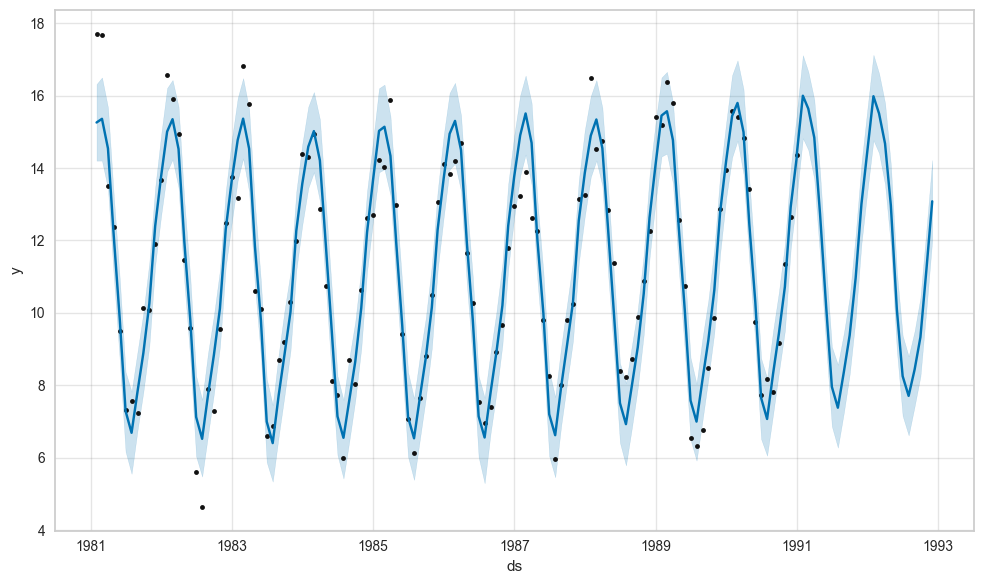

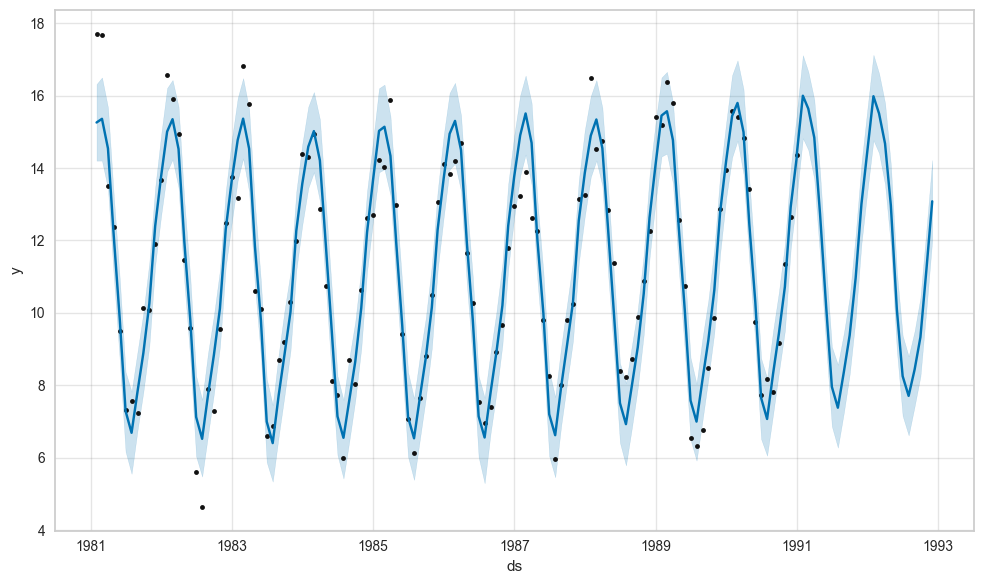

In [74]:
m.plot(forecast)

In [82]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# m.plot(forecast)
# plt.xlim('1991-10-01','1992-12-01')

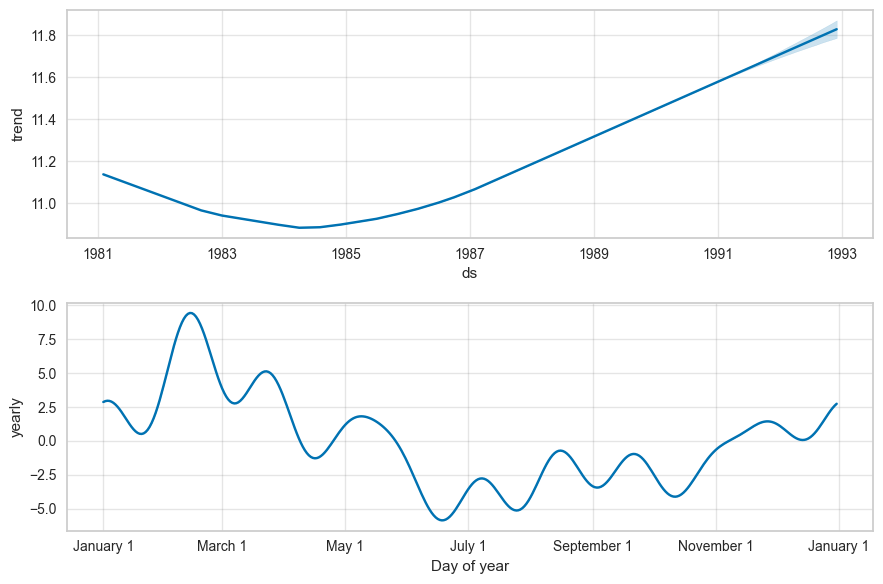

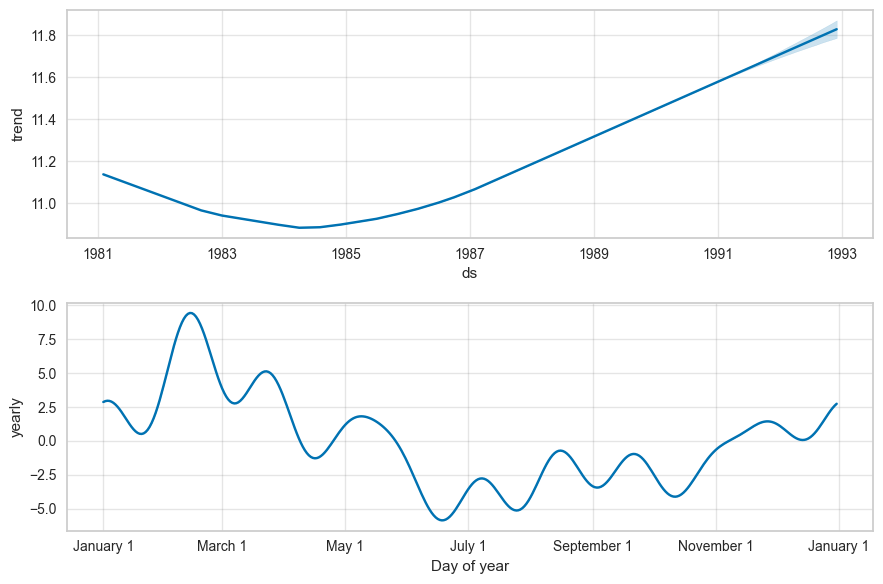

In [83]:
m.plot_components(forecast)

## Downloading time series data (stocks market)

In [87]:
import requests
from bs4 import BeautifulSoup

In [ ]:
import requests
from bs4 import BeautifulSoup

# Example: Scrape stock data table from a website
url = "https://example.com/stocks/AAPL"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
# Find the table and extract data using BeautifulSoup methods
